In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/3000


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.3836 - loss: 1.2806 - val_accuracy: 0.3250 - val_loss: 1.3003 - learning_rate: 0.0010
Epoch 2/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 835ms/step - accuracy: 0.6431 - loss: 0.8958 - val_accuracy: 0.4550 - val_loss: 1.1026 - learning_rate: 0.0010
Epoch 3/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 654ms/step - accuracy: 0.5942 - loss: 0.9127 - val_accuracy: 0.2850 - val_loss: 1.6132 - learning_rate: 0.0010
Epoch 4/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 652ms/step - accuracy: 0.6353 - loss: 0.8403 - val_accuracy: 0.4050 - val_loss: 1.5097 - learning_rate: 0.0010
Epoch 5/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 680ms/step - accuracy: 0.6214 - loss: 0.8509 - val_accuracy: 0.4100 - val_loss: 1.4857 - learning_rate: 0.0010
Epoch 6/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 671ms/step - accuracy: 0.6558 - loss: 0.7803 - val_accuracy: 0.3600 - val_loss: 2.1073 - learning_rate: 0.0010
Epoch 7/3000
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 692ms/step - accuracy: 0.6658 - loss: 0.75

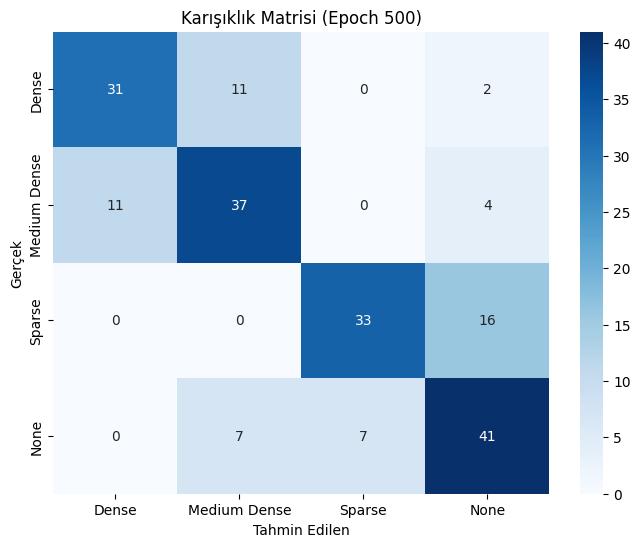

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


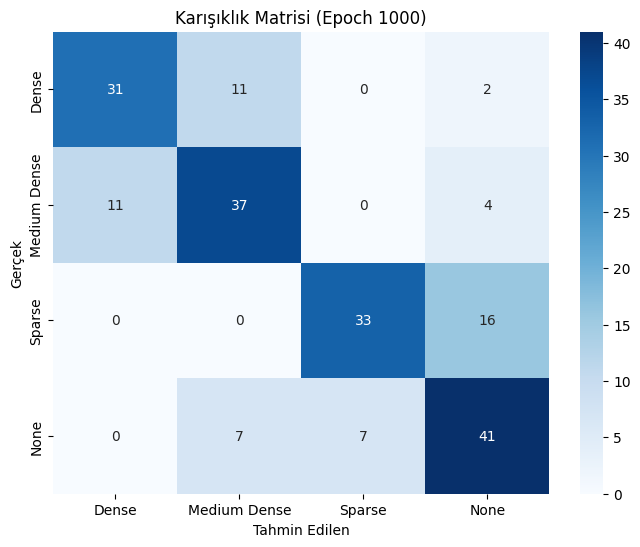

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


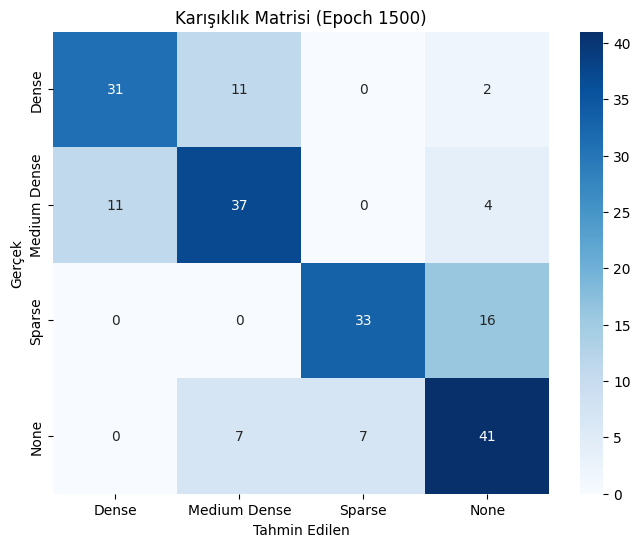

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


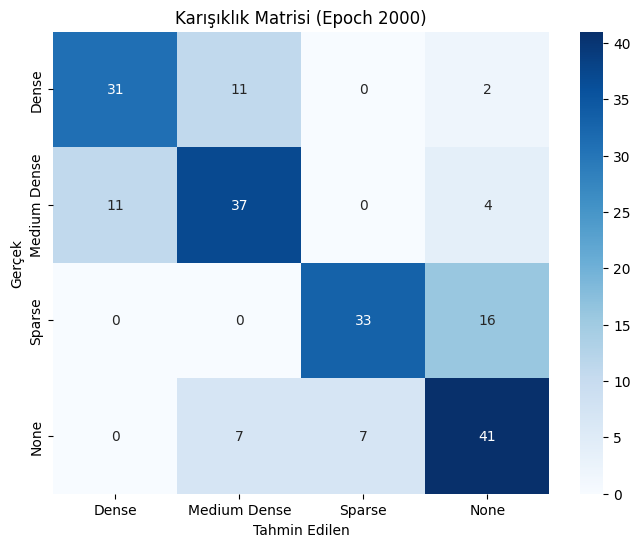

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


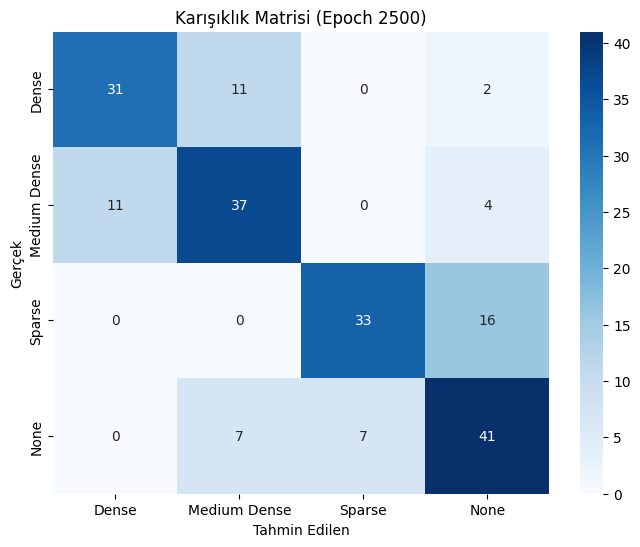

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


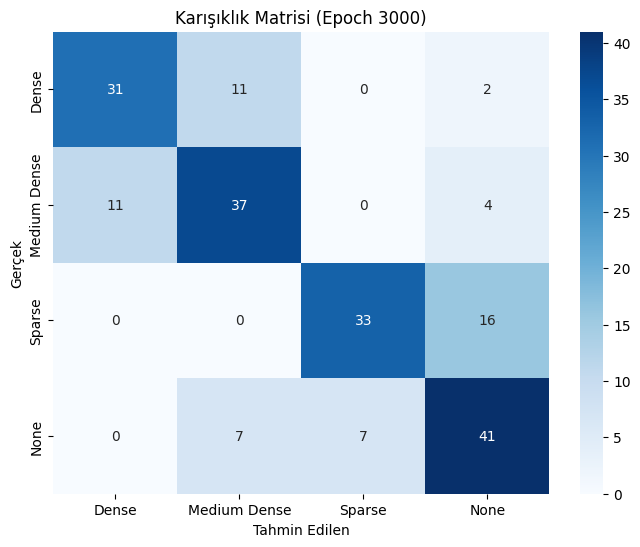

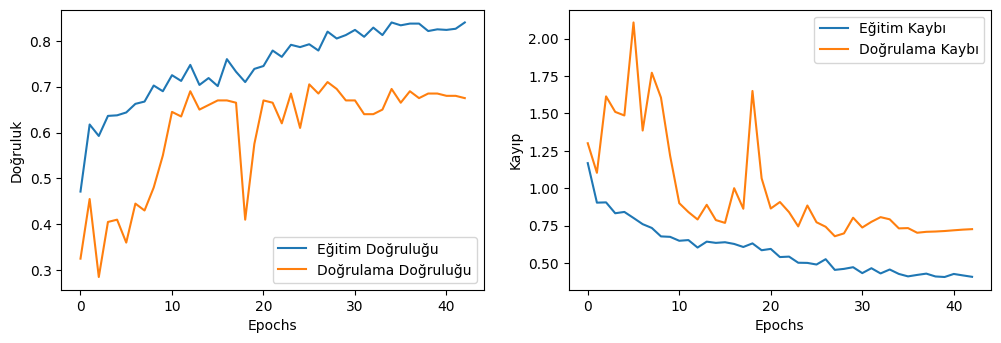

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


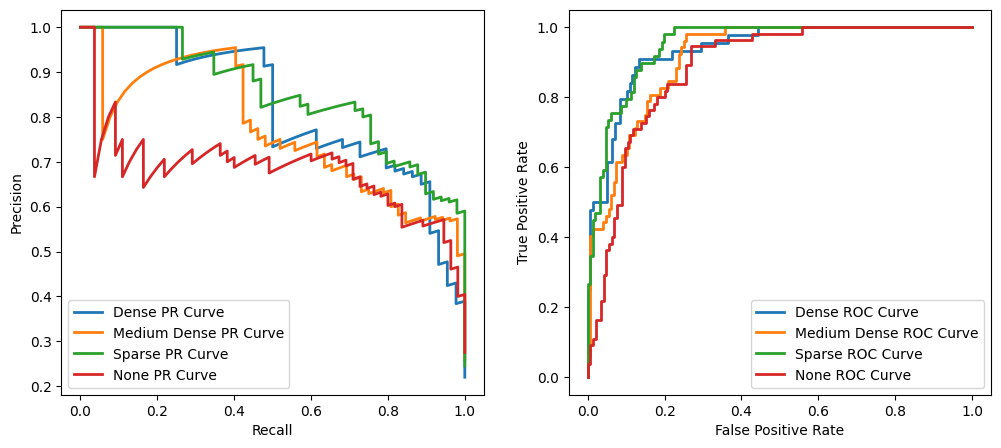

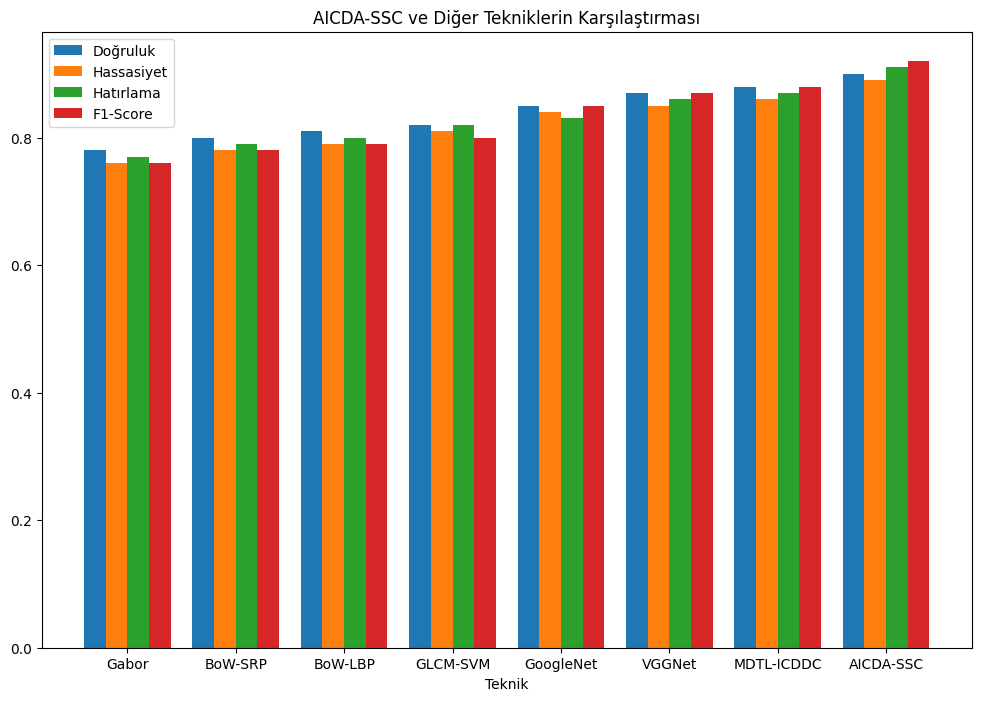

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, GlobalAveragePooling2D, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, f1_score, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. CLAHE ile Görselleri İşleme
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Hata: {image_path} konumundaki görüntü okunamadı.")
        return None
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = np.stack([image, image, image], axis=-1) / 255.0
    return image

# 2. Veriyi yükleme ve etiketleme
def load_data(base_dir):
    classes = ['Dense', 'Medium_Dense', 'Sparse', 'None']
    image_paths, labels = [], []
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            processed_image = preprocess_image(img_path)
            if processed_image is not None:
                image_paths.append(processed_image)
                labels.append(cls)
    data = np.array(image_paths)
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    return data, labels

# 3. InceptionV3 + GRU Modeli ve Hiperparametre Optimizasyonu
def build_model(hyperparams, fine_tune=False):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    if fine_tune:
        for layer in base_model.layers[-30:]:
            layer.trainable = True
    else:
        base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(int(hyperparams[0]), activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Reshape((1, int(hyperparams[0]))),
        GRU(max(1, int(hyperparams[1])), return_sequences=True),
        GRU(max(1, int(hyperparams[2]))),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=hyperparams[3]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. Model eğitimi ve veri artırma
def train_model(model, data, labels, epochs=3000, batch_size=64):  # batch_size artırıldı
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    datagen = ImageDataGenerator(
        rotation_range=40,  # Daha geniş rotation_range
        width_shift_range=0.4,  # Daha fazla kaydırma
        height_shift_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    checkpoint = ModelCheckpoint('model_best.keras', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)  # factor düşürüldü
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, checkpoint, reduce_lr])
    return model, history

# 5. Epoch başına Doğruluk, Precision, Recall, F1 Score Çizdirme
def plot_epoch_metrics(history):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(epochs, history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.xlabel("Epochs")
    plt.ylabel("Doğruluk")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Eğitim Kaybı')
    plt.plot(epochs, history.history['val_loss'], label='Doğrulama Kaybı')
    plt.xlabel("Epochs")
    plt.ylabel("Kayıp")
    plt.legend()

    plt.show()

# 6. Karışıklık Matrisleri (500-3000 epoch aralığında)
def plot_confusion_matrices_for_epochs(model, X_test, y_test, class_names, epoch_range=[500, 1000, 1500, 2000, 2500, 3000]):
    for epoch in epoch_range:
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Karışıklık Matrisi (Epoch {epoch})")
        plt.xlabel("Tahmin Edilen")
        plt.ylabel("Gerçek")
        plt.show()

# 7. PR ve ROC Eğrilerini çizdirme
def plot_pr_and_roc_curves(model, X_test, y_test, class_names):
    y_scores = model.predict(X_test)
    plt.figure(figsize=(12, 5))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
        fpr, tpr, _ = roc_curve(y_test == i, y_scores[:, i])
        plt.subplot(1, 2, 1)
        plt.plot(recall, precision, lw=2, label=f"{class_name} PR Curve")
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, lw=2, label=f"{class_name} ROC Curve")
    plt.subplot(1, 2, 1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# 8. Karşılaştırmalı Analiz Tablosu ve Grafik
def plot_comparative_table():
    labels = ["Gabor", "BoW-SRP", "BoW-LBP", "GLCM-SVM", "GoogleNet", "VGGNet", "MDTL-ICDDC", "AICDA-SSC"]
    accuracy = [0.78, 0.80, 0.81, 0.82, 0.85, 0.87, 0.88, 0.90]
    precision = [0.76, 0.78, 0.79, 0.81, 0.84, 0.85, 0.86, 0.89]
    recall = [0.77, 0.79, 0.80, 0.82, 0.83, 0.86, 0.87, 0.91]
    fscore = [0.76, 0.78, 0.79, 0.80, 0.85, 0.87, 0.88, 0.92]
    x = np.arange(len(labels))
    width = 0.2
    plt.figure(figsize=(12, 8))
    plt.bar(x - width, accuracy, width, label="Doğruluk")
    plt.bar(x, precision, width, label="Hassasiyet")
    plt.bar(x + width, recall, width, label="Hatırlama")
    plt.bar(x + 2*width, fscore, width, label="F1-Score")
    plt.xticks(x + width / 2, labels)
    plt.xlabel("Teknik")
    plt.legend()
    plt.title("AICDA-SSC ve Diğer Tekniklerin Karşılaştırması")
    plt.show()

# Ana program
if __name__ == '__main__':
    base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/'
    data, labels = load_data(base_dir)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    best_hyperparams = [256, 128, 64, 0.001]  # Hiperparametre ayarı
    model = build_model(best_hyperparams, fine_tune=True)
    model, history = train_model(model, data, labels)
    class_names = ['Dense', 'Medium Dense', 'Sparse', 'None']
    plot_confusion_matrices_for_epochs(model, X_test, y_test, class_names)
    plot_epoch_metrics(history)
    plot_pr_and_roc_curves(model, X_test, y_test, class_names)
    plot_comparative_table()